In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/Siamese/Speaker'

/content/drive/My Drive/Siamese/Speaker


In [ ]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder/Freq')
sys.path.insert(0, '../Encoder/Time')
sys.path.insert(0, '../Encoder/')
sys.path.insert(0, '../Conference')
sys.path.insert(0, '../Place')

In [ ]:
!pip install torchaudio

     |████████████████████████████████| 6.7MB 2.6MB/s 


In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [ ]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
MODEL_PATH = '/content/drive/My Drive/Siamese/net.nn'
EPOCH_NUM = 6
SPEAKERS_NUM = 20

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [ ]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from torchvision.transforms import Compose
from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                SPEAKERS_NUM,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3
lenght test loader  2134


In [ ]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = Conference(DEVICE,
              time=False)

net.load_encoder(size=2)
net.to(DEVICE)

cuda
Encoder loaded


Conference(
  (encoder): TransFourier(
    (spectrogram): Spectrogram()
    (amp): AmplitudeToDB()
    (block1): Conv2DBlock(
      (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv2DBlock(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv2DBlock(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Co

In [ ]:
with torch.no_grad():
  # test
  net.eval()
  # Store the speakers
  speakers_list = testset.get_speakers_list(20)
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list)

In [ ]:
import numpy as np

dict_error = {}
dict_nb = {}

conf_gold_label = None
conf_pred_label = None

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    nb_test = 0
    if epoch_num == EPOCH_NUM-1:
      print("activate stats")
      net.activatestats()
      # Confusion matrix
      conf_gold_label = []
      conf_pred_label = []

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, topk_label, min_label = net(sample, gold_label)
      if conf_gold_label != None:
        conf_gold_label.append(gold_label)
      if conf_pred_label != None:
        conf_pred_label.append(min_label)      

      nb_test += 1
      gold_label = gold_label.item()
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

  net.store_speakers(20, 3)
  means = net.dumpstats()

*** Epoch  0  ***


2134it [01:35, 22.44it/s]

accuracy mean  0.2539831302717901 topk 0.6940018744142455  min  0.6935332708528584
Error  0.30599812558575445
{270: 10, 272: 18, 273: 23, 274: 31, 275: 16, 276: 24, 277: 31, 278: 12, 271: 26, 279: 98, 280: 41, 281: 14, 282: 78, 283: 38, 285: 94, 284: 30, 286: 2, 287: 43, 288: 43, 289: 16}
*** Epoch  1  ***



2134it [00:42, 50.65it/s]

accuracy mean  0.5192127460168697 topk 0.7717900656044986  min  0.7582005623242737
Error  0.2282099343955014
{270: 16, 272: 22, 273: 29, 274: 25, 275: 20, 276: 15, 277: 29, 278: 7, 271: 16, 279: 52, 280: 19, 281: 26, 282: 32, 283: 31, 285: 65, 284: 6, 286: 3, 287: 39, 288: 25, 289: 6}
*** Epoch  2  ***



2134it [00:42, 49.91it/s]

accuracy mean  0.6180880974695407 topk 0.781630740393627  min  0.7760074976569822
Error  0.21836925960637302
{270: 20, 272: 20, 273: 34, 274: 12, 275: 13, 276: 14, 277: 19, 278: 4, 271: 16, 279: 26, 280: 17, 281: 32, 282: 21, 283: 43, 285: 45, 284: 3, 286: 6, 287: 37, 288: 12, 289: 10}
*** Epoch  3  ***



2134it [00:43, 48.88it/s]

accuracy mean  0.718369259606373 topk 0.7872539831302718  min  0.7839737582005624
Error  0.21274601686972822
{270: 21, 272: 24, 273: 36, 274: 12, 275: 10, 276: 16, 277: 23, 278: 8, 271: 12, 279: 26, 280: 13, 281: 33, 282: 15, 283: 46, 285: 30, 284: 2, 286: 5, 287: 22, 288: 6, 289: 8}
*** Epoch  4  ***



2134it [00:42, 50.01it/s]

accuracy mean  0.7310215557638238 topk 0.788191190253046  min  0.7788191190253045
Error  0.21180880974695407
{270: 18, 272: 24, 273: 38, 274: 12, 275: 12, 276: 14, 277: 26, 278: 6, 271: 12, 279: 23, 280: 13, 281: 34, 282: 25, 283: 44, 285: 27, 284: 2, 286: 5, 287: 29, 288: 4, 289: 4}
*** Epoch  5  ***
activate stats



2134it [00:45, 47.05it/s]


accuracy mean  0.7141518275538894 topk 0.7699156513589503  min  0.7633552014995314
Error  0.23008434864104968
{270: 19, 272: 26, 273: 40, 274: 12, 275: 13, 276: 21, 277: 25, 278: 6, 271: 17, 279: 25, 280: 13, 281: 34, 282: 25, 283: 47, 285: 31, 284: 1, 286: 4, 287: 37, 288: 4, 289: 10}
Stats for  270  :  tensor([ 7.0013,  7.2805,  7.7863,  8.0193,  8.2350,  8.4042,  8.5418,  8.6673,
         8.7831,  8.9059,  9.0484,  9.1984,  9.3838,  9.5764,  9.9991, 10.1710,
        10.3414, 10.5480, 10.7647, 11.1096], device='cuda:0')
Stats for  272  :  tensor([ 6.8022,  7.2550,  7.5565,  7.7825,  7.9629,  8.1125,  8.2495,  8.3796,
         8.5079,  8.6393,  8.7479,  8.8658,  8.9974,  9.1396,  9.3204,  9.6806,
         9.8558, 10.0344, 10.2475, 10.5986], device='cuda:0')
Stats for  273  :  tensor([ 7.2604,  7.6587,  7.9177,  8.0752,  8.2067,  8.3354,  8.4726,  8.6030,
         8.7254,  8.8393,  8.9474,  9.0549,  9.1651,  9.2703,  9.3869,  9.5183,
         9.6755,  9.8480, 10.0679, 10.3598], device=

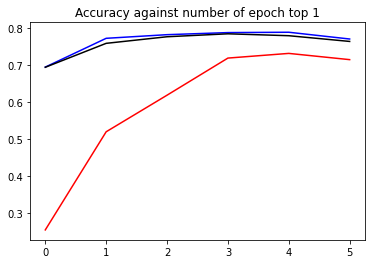

In [ ]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='black')


In [ ]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))


maximum of min 0.784
maximum of topk 0.788
maximum of mean 0.731


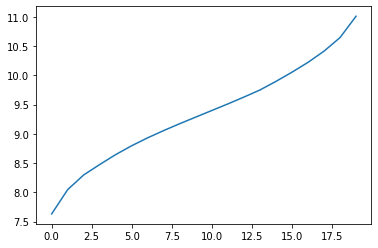

In [ ]:
plt.plot(means.cpu())

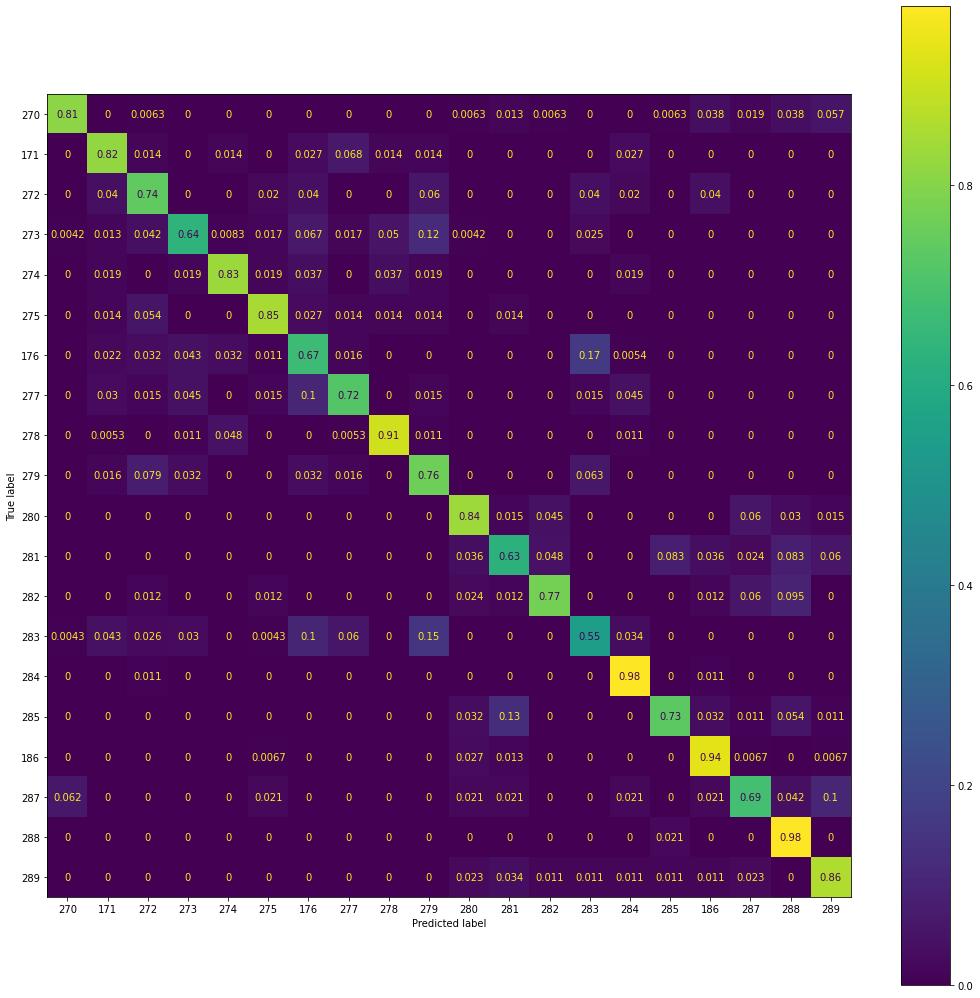

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(conf_gold_label, conf_pred_label, normalize='true')
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(cm, [270, 171, 272, 273, 274, 275, 176, 277, 278, 279, 280, 281, 282, 283, 284, 285, 186, 287, 288, 289]).plot(ax=ax)
plt.show()

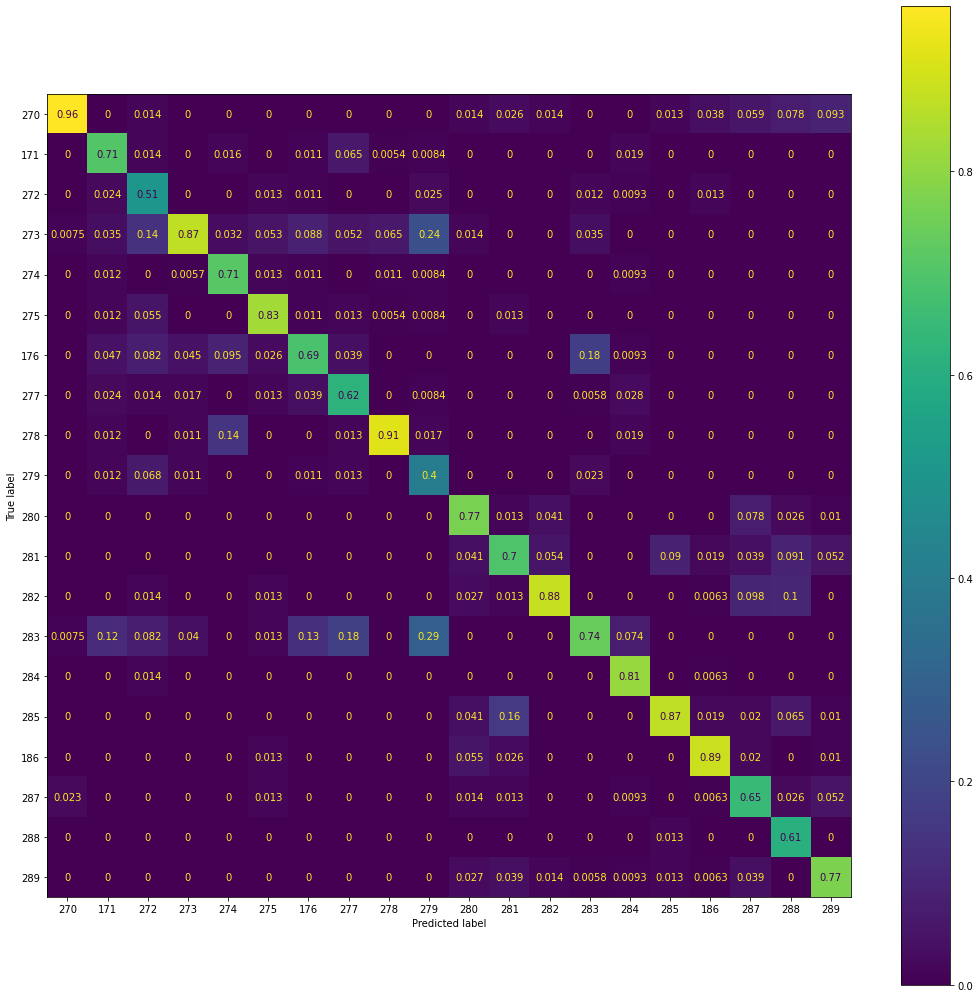

In [ ]:
cm = confusion_matrix(conf_gold_label, conf_pred_label, normalize='pred')
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(cm, [270, 171, 272, 273, 274, 275, 176, 277, 278, 279, 280, 281, 282, 283, 284, 285, 186, 287, 288, 289]).plot(ax=ax)
plt.show()

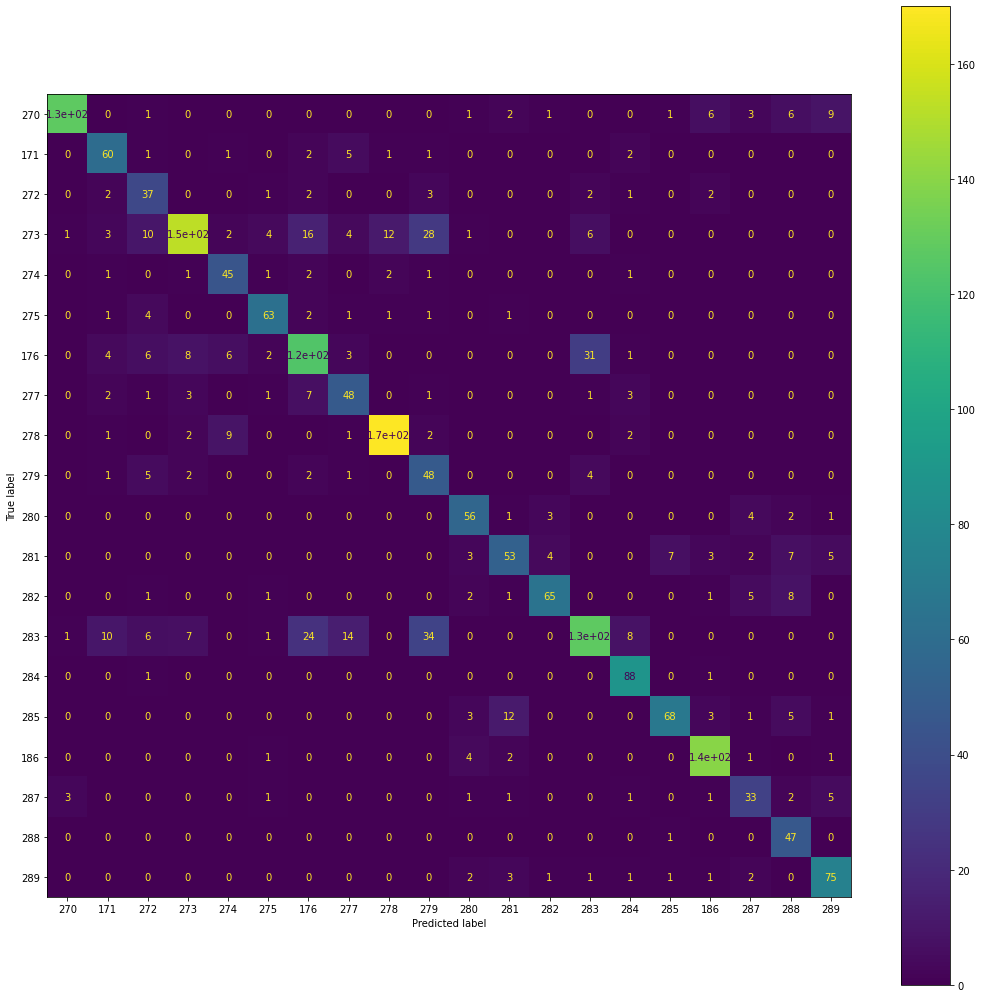

In [ ]:
cm = confusion_matrix(conf_gold_label, conf_pred_label)
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(cm, [270, 171, 272, 273, 274, 275, 176, 277, 278, 279, 280, 281, 282, 283, 284, 285, 186, 287, 288, 289]).plot(ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import f1_score

score = f1_score(conf_gold_label, conf_pred_label, average='micro')
print(score)
score = f1_score(conf_gold_label, conf_pred_label, average='weighted')
print(score)

0.7633552014995314
0.7650548208400152
